In [25]:
import os, numpy as np, matplotlib.pyplot as plt, pandas as pd, sklearn.model_selection, tensorflow as tf
from PIL import Image
from json import dumps
from tensorflow import keras


dataset_path = "../notMNIST_large"
img_size = 28
px_depth = 255.0

# 1. Dataset preparation

## 1.1. Dataset loading

In [26]:
def load_letter(path, imgs_count = None):
    img_names = os.listdir(path)
    max_processed_imgs_count = imgs_count if imgs_count is not None else len(img_names)
    res_dataset = []

    processed_img_idx = 0
    while processed_img_idx < max_processed_imgs_count:
        img_name = img_names[processed_img_idx]
        img_path = os.path.join(path, img_name)
        try:
            img_data = Image.open(img_path)
            img_table = np.array(img_data) / px_depth
            img_row = np.reshape(img_table, img_table.shape[0]*img_table.shape[1], order='C')
            res_dataset += [img_row]
            processed_img_idx = processed_img_idx + 1
        except (IOError, ValueError) as e:
            print('Could not read:', img_path, ':', e, '! File will be skipped.')

    print(path, 'Full dataset tensor: ', len(res_dataset))
    return res_dataset


def load_datasets(path, imgs_count = None):
    folder_paths = os.listdir(path)
    res_letter_dataset = None
    res_label_dataset = None

    for folder_path in folder_paths:
        cur_letter_dataset = load_letter(path + "/"  + folder_path, imgs_count)
        cur_label_dataset = [folder_path] * len(cur_letter_dataset)

        res_letter_dataset = cur_letter_dataset if res_letter_dataset is None \
            else (res_letter_dataset + cur_letter_dataset)

        res_label_dataset = cur_label_dataset if res_label_dataset is None \
            else (res_label_dataset + cur_label_dataset)

    return res_letter_dataset, res_label_dataset


x, y =  load_datasets(dataset_path, 8000)

../notMNIST_large/A Full dataset tensor:  8000
../notMNIST_large/B Full dataset tensor:  8000
../notMNIST_large/C Full dataset tensor:  8000
../notMNIST_large/D Full dataset tensor:  8000
../notMNIST_large/E Full dataset tensor:  8000
../notMNIST_large/F Full dataset tensor:  8000
../notMNIST_large/G Full dataset tensor:  8000
../notMNIST_large/H Full dataset tensor:  8000
../notMNIST_large/I Full dataset tensor:  8000
../notMNIST_large/J Full dataset tensor:  8000


## 1.2. Samples dividing and duplicates deleting

In [27]:
def get_array_without_idxs(sample, deleted_idx_list):
    unique_sample = [i for j, i in enumerate(sample) if j not in deleted_idx_list]
    return unique_sample


def get_unique_sample(x, y):
    img_array_strings = [dumps(row.tolist()) for row in x]

    data = {'letter': y,
            'img_array': x,
            'img_array_string': img_array_strings}
    df = pd.DataFrame.from_dict(data)
    df = df.reset_index()

    bool_series = df['img_array_string'].duplicated(keep = 'first')
    duplicates = df[bool_series]
    duplicate_idx_list = duplicates['index'].tolist()

    unique_x = get_array_without_idxs(x, duplicate_idx_list)
    unique_y = get_array_without_idxs(y, duplicate_idx_list)

    return unique_x, unique_y

In [28]:
def get_samples(x, y, train_sample_count, validation_sample_count, test_sample_count):
    total_count = len(x)

    sample_count = train_sample_count + validation_sample_count + test_sample_count

    rest_x, sample_x, rest_y, sample_y = sklearn.model_selection.train_test_split(
        x, y, test_size=sample_count/total_count, random_state=42)

    train_x, test_validation_x, train_y, test_validation_y = sklearn.model_selection.train_test_split(
        sample_x, sample_y, test_size=(validation_sample_count + test_sample_count)/sample_count, random_state=42)

    validation_x, test_x, validation_y, test_y = sklearn.model_selection.train_test_split(
        test_validation_x, test_validation_y, test_size=test_sample_count/(validation_sample_count + test_sample_count), random_state=42)
    return train_x, train_y, validation_x, validation_y, test_x, test_y

train_x, train_y, validation_x, validation_y, test_x, test_y = get_samples(x, y, 50000, 10000, 19000)

old_len = len(train_y)
train_x, train_y = get_unique_sample(train_x, train_y)
print(f'There was {old_len - len(train_y)} duplicates in train sample')

old_len = len(validation_y)
validation_x, validation_y = get_unique_sample(validation_x, validation_y)
print(f'There was {old_len - len(validation_y)} duplicates in validation sample')

old_len = len(test_y)
test_x, test_y = get_unique_sample(test_x, test_y)
print(f'There was {old_len - len(test_y)} duplicates in test sample')

There was 4091 duplicates in train sample
There was 274 duplicates in validation sample
There was 742 duplicates in test sample


## 1.3. Check are classes balanced

Variance for train sample is: 19747.69


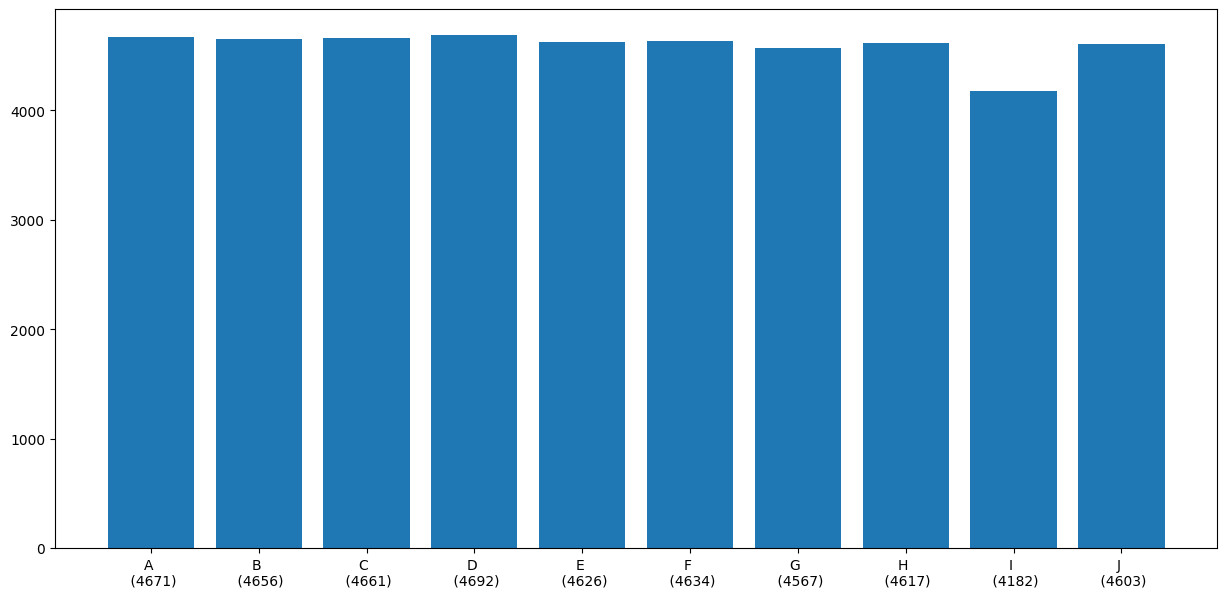

Variance for validation sample is: 411.0400000000001


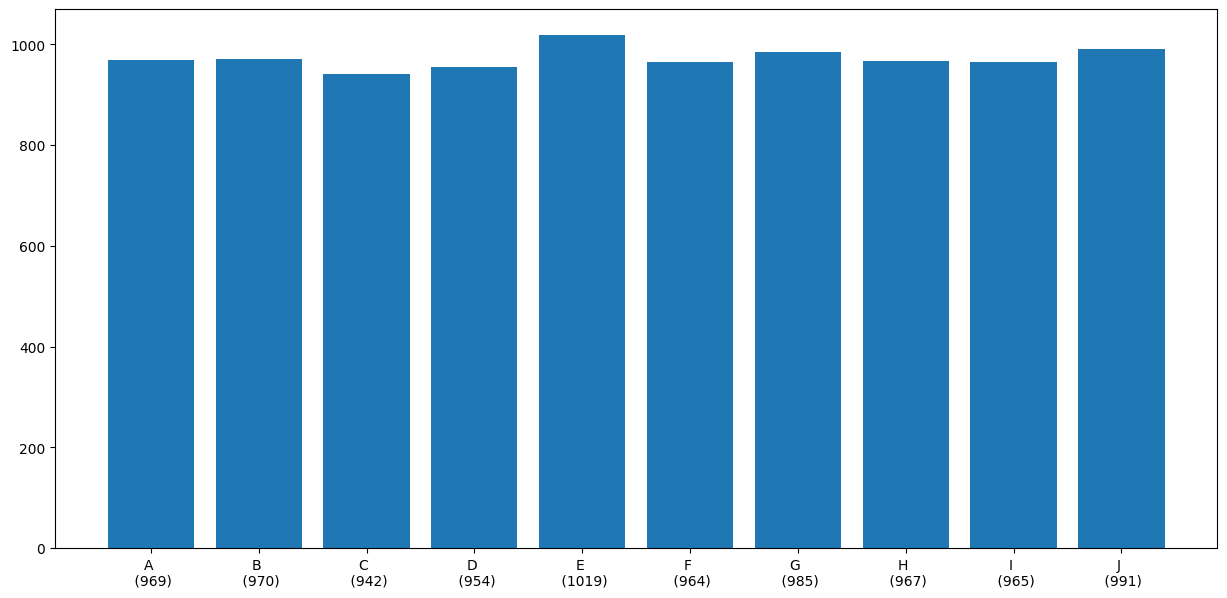

Variance for test sample is: 2696.56


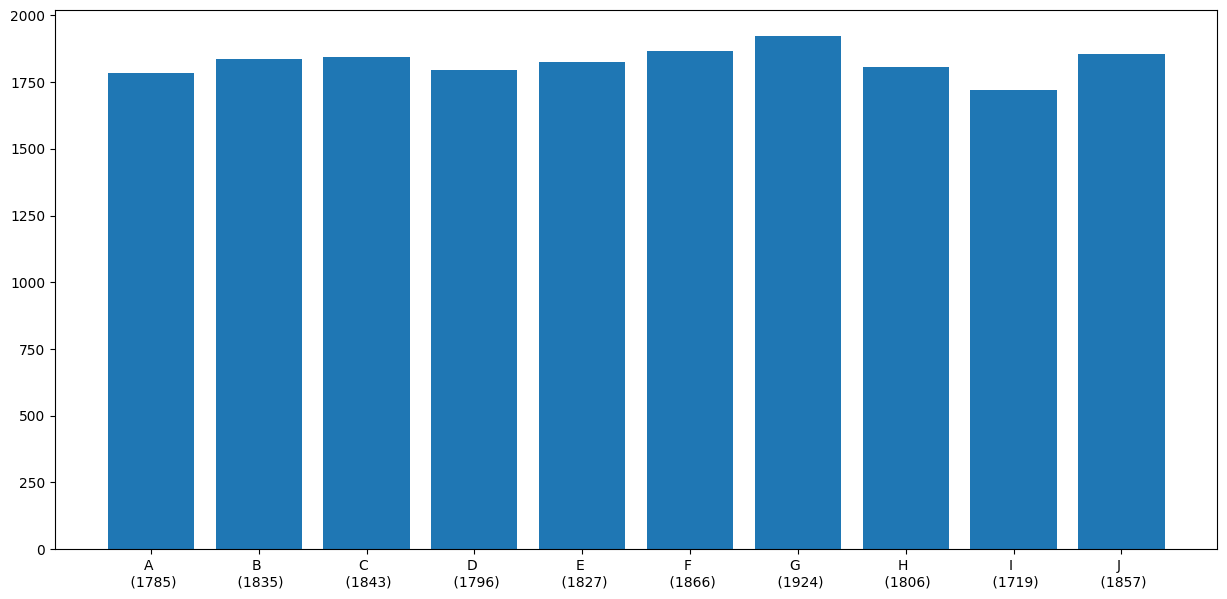

In [29]:
def get_class_counts(labels):
    labels_df = pd.DataFrame.from_dict({'letter': labels})
    counter_df = labels_df.groupby(['letter'])['letter'].count().reset_index(name='count')
    letters = counter_df['letter'].tolist()
    letter_counts = counter_df['count'].tolist()

    result_dict = {letters[i]: letter_counts[i] for i in range(len(letters))}
    return result_dict

def show_bar_graph(plt_data_dict, sample_name):
    letter_count_labels = []
    letter_counts = []

    variance = np.var(list(plt_data_dict.values()))
    print(f'Variance for {sample_name} sample is: {variance}')

    for key in plt_data_dict.keys():
        letter_count_labels.append(f'{key} \n ({plt_data_dict[key]})')
        letter_counts.append(plt_data_dict[key])

    f = plt.figure()
    f.set_figwidth(15)
    f.set_figheight(7)

    plt.bar(letter_count_labels, letter_counts)
    plt.show()

samples_data_list = [
    {'x': train_x, 'y': train_y, 'name': 'train', 'classes_dict': None},
    {'x': validation_x, 'y': validation_y, 'name': 'validation', 'classes_dict': None},
    {'x': test_x, 'y': test_y, 'name': 'test', 'classes_dict': None}
]

for i in range(len(samples_data_list)):
    sample_data = samples_data_list[i]
    plt_data_dict = get_class_counts(sample_data['y'])
    samples_data_list[i]['classes_dict'] = plt_data_dict
    show_bar_graph(plt_data_dict, sample_data['name'])

## 1.4. Balancing

Variance for train sample is: 0.0


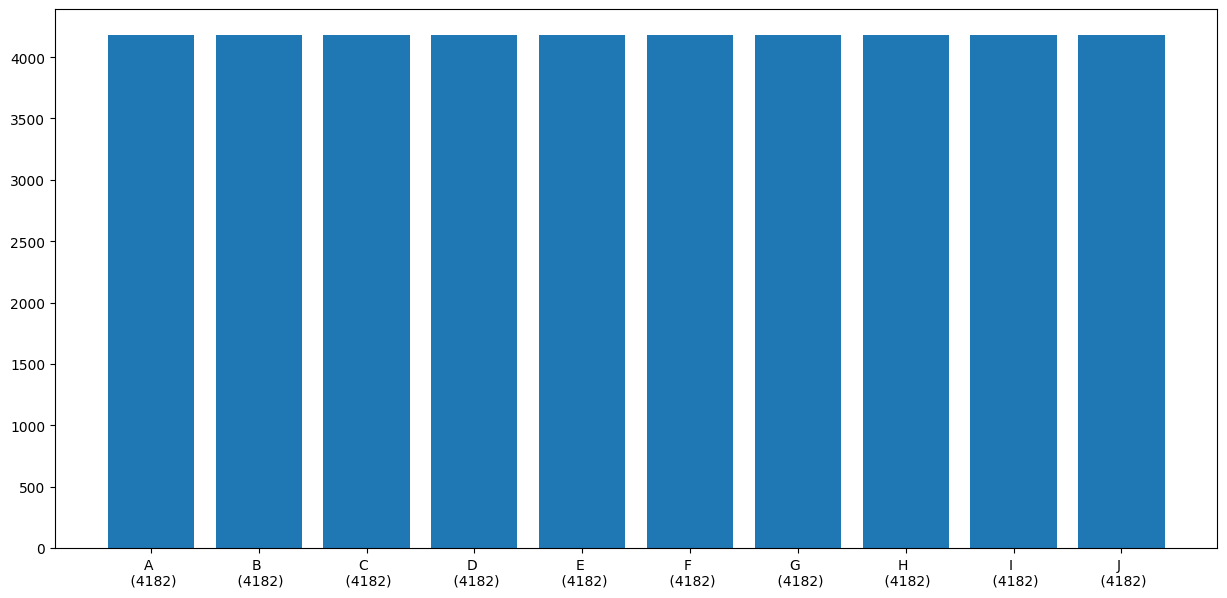

Variance for validation sample is: 0.0


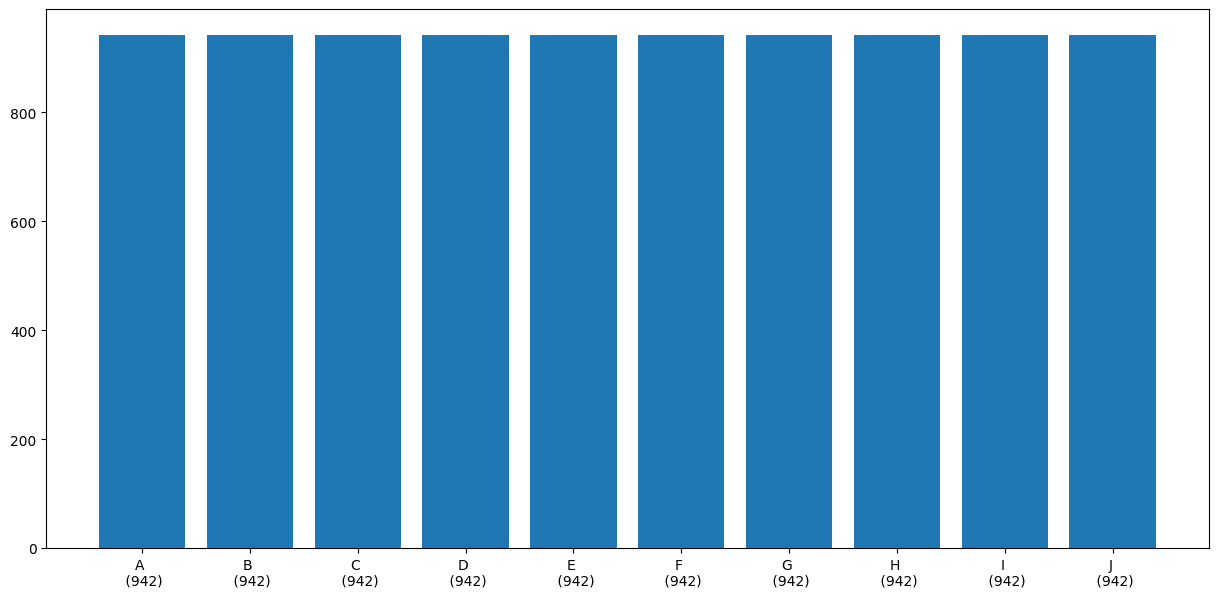

Variance for test sample is: 0.0


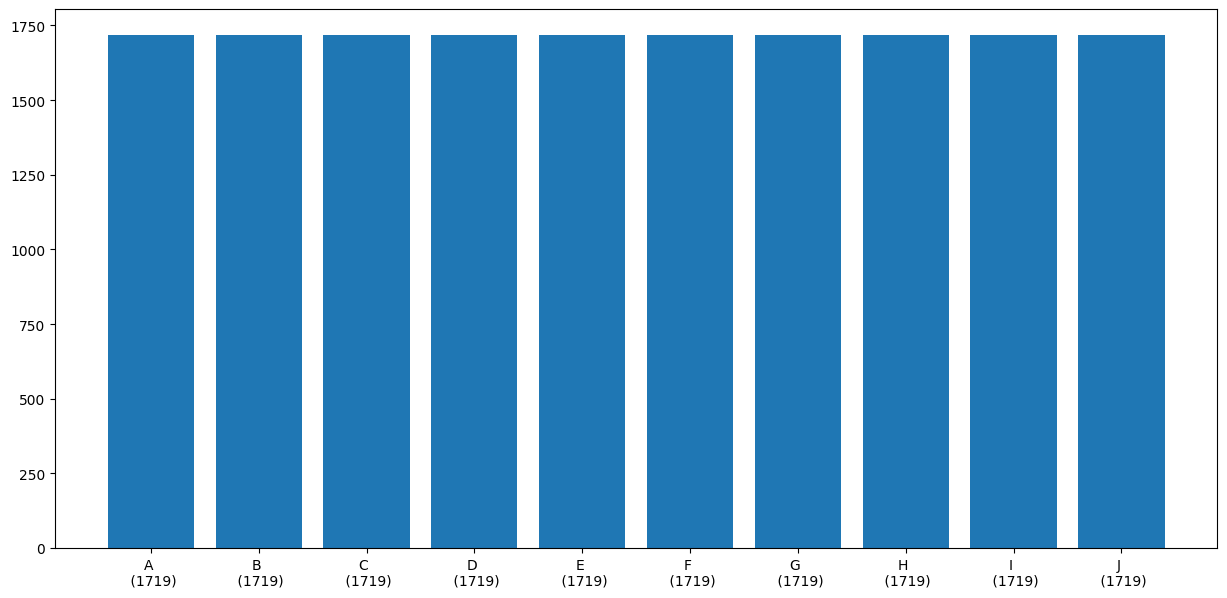

In [30]:
def balance_with_undersampling(x, y, classes_dict):
    min_class_count = min(list(classes_dict.values()))
    data = {'letter': y}
    df = pd.DataFrame.from_dict(data)
    df = df.reset_index()
    removed_idxs=[]
    for class_name in classes_dict.keys():
        deleted_count = classes_dict[class_name] - min_class_count
        if deleted_count > 0:
            class_df = (df.loc[df['letter'] == class_name]).head(deleted_count)
            removed_idxs += class_df['index'].tolist()
    unique_x = get_array_without_idxs(x, removed_idxs)
    unique_y = get_array_without_idxs(y, removed_idxs)
    return unique_x, unique_y


for i in range(len(samples_data_list)):
    sample_data = samples_data_list[i]
    x, y, classes_dict = sample_data['x'], sample_data['y'], sample_data['classes_dict']
    samples_data_list[i]['x'], samples_data_list[i]['y'] = balance_with_undersampling(x, y, classes_dict)

for i in range(len(samples_data_list)):
    sample_data = samples_data_list[i]
    plt_data_dict = get_class_counts(sample_data['y'])
    samples_data_list[i]['classes_dict'] = plt_data_dict
    show_bar_graph(plt_data_dict, sample_data['name'])

In [31]:
def prepare_data(x, y):
    images = [elem.tolist() for elem in x]
    labels = [ord(elem) - ord('A') for elem in y]
    return images, labels

for i in range(len(samples_data_list)):
    x, y = samples_data_list[i]['x'], samples_data_list[i]['y']
    samples_data_list[i]['x'], samples_data_list[i]['y'] = prepare_data(x, y)

    print(f'Data for {samples_data_list[i]["name"]} sample: x_count:{len(samples_data_list[i]["x"])}; y_count: {len(samples_data_list[i]["y"])}')

Data for train sample: x_count:41820; y_count: 41820
Data for validation sample: x_count:9420; y_count: 9420
Data for test sample: x_count:17190; y_count: 17190


# 2. Neural networks creating

In [32]:
epochs = 50
neurons_list = [510, 510, 250, 200, 150]
activation_funcs = {'piecewise_linear': tf.nn.relu, 'sigmoid': tf.nn.sigmoid ,'hyperbolic_tangent': tf.nn.tanh}
optimizer = tf.optimizers.SGD()
output_layer = keras.layers.Dense(10, activation=tf.nn.softmax)

## 2.1. Simple model

In [33]:
def get_simple_model_by_func_name(func_name):
    layers_list = [keras.layers.Dense(n, activation=activation_funcs[func_name]) for n in neurons_list]
    layers_list.append(output_layer)
    simple_model = keras.Sequential(layers_list)
    simple_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return simple_model

## 2.2. Regularized model

In [34]:
regularization_rate = 1e-3


def get_regularized_model_by_func_name(func_name):
    layers_list = [keras.layers.Dense(n, activation=activation_funcs[func_name], kernel_regularizer=keras.regularizers.l2(regularization_rate)) for n in neurons_list]
    layers_list.append(output_layer)
    regularized_model = keras.Sequential(layers_list)
    regularized_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return regularized_model

## 2.3. Dropout model

In [35]:
dropout_rate = 0.4


def get_dropout_model_by_func_name(func_name):
    layers_list = []
    for n in neurons_list:
        layers_list.append(keras.layers.Dense(n, activation=activation_funcs[func_name], kernel_regularizer=keras.regularizers.l2(regularization_rate)))
        layers_list.append(keras.layers.Dropout(dropout_rate))
    layers_list.append(output_layer)
    dropout_model = keras.Sequential(layers_list)
    dropout_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return dropout_model

## 2.4. Dynamic rate madel

In [36]:
def get_dynamic_rate_model_by_func_name(func_name):
    layers_list = []
    for n in neurons_list:
        layers_list.append(keras.layers.Dense(n, activation=activation_funcs[func_name], kernel_regularizer=keras.regularizers.l2(regularization_rate)))
        layers_list.append(keras.layers.Dropout(dropout_rate))
    layers_list.append(output_layer)
    dynamic_rate_model = keras.Sequential(layers_list)
    dynamic_rate_model.compile(optimizer=tf.optimizers.Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return dynamic_rate_model

## 2.3. Validation for choose best activation function

In [37]:
def train_model(model, x, y):
    history = model.fit(x, y, epochs=epochs)
    return model, history


def test_model(model, x, y):
    losses, accuracies = model.evaluate(x, y)
    return losses, accuracies

In [38]:
def validate_with_functions(create_func):
    validation_sample_data = list(filter(lambda elem: elem['name'] == 'validation', samples_data_list))[0]
    train_sample_data = list(filter(lambda elem: elem['name'] == 'train', samples_data_list))[0]

    validation_x, validation_y = validation_sample_data['x'], validation_sample_data['y']
    train_x, train_y = train_sample_data['x'], train_sample_data['y']

    print(len(train_x))
    print(len(train_x[0]))
    print(len(train_y))
    print()
    print(len(validation_x))
    print(len(validation_x[0]))
    print(len(validation_y))

    accur_to_model_map = {}
    histories = {}

    for func_name in activation_funcs.keys():
        model = create_func(func_name)
        trained_model, history = train_model(model, train_x, train_y)
        accuracy, loss = test_model(trained_model, validation_x, validation_y)
        accur_to_model_map[accuracy] = trained_model
        histories[func_name] = history

    best_accur = max(list(accur_to_model_map.keys()))
    returned_model = accur_to_model_map[best_accur]

    return returned_model, histories

41820
784
41820

9420
784
9420
Epoch 1/50
1307/1307 [==============================] - 16s 9ms/step - loss: 0.8276 - accuracy: 0.7706
Epoch 2/50
1307/1307 [==============================] - 12s 9ms/step - loss: 0.5416 - accuracy: 0.8434
Epoch 3/50
1307/1307 [==============================] - 13s 10ms/step - loss: 0.4859 - accuracy: 0.8571
Epoch 4/50
1307/1307 [==============================] - 12s 9ms/step - loss: 0.4498 - accuracy: 0.8663
Epoch 5/50
1307/1307 [==============================] - 12s 9ms/step - loss: 0.4166 - accuracy: 0.8767
Epoch 6/50
1307/1307 [==============================] - 12s 9ms/step - loss: 0.3894 - accuracy: 0.8846
Epoch 7/50
1307/1307 [==============================] - 12s 9ms/step - loss: 0.3628 - accuracy: 0.8923
Epoch 8/50
1307/1307 [==============================] - 12s 9ms/step - loss: 0.3373 - accuracy: 0.9000
Epoch 9/50
1307/1307 [==============================] - 13s 10ms/step - loss: 0.3134 - accuracy: 0.9059
Epoch 10/50
1307/1307 [=================

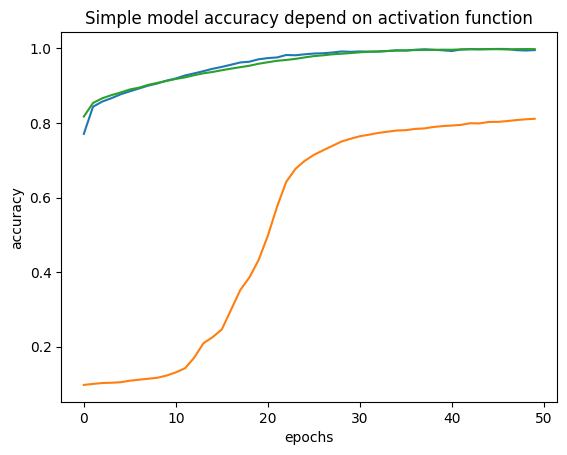

In [39]:
simple_model, histories = validate_with_functions(get_simple_model_by_func_name)

Max accuracy for piecewise_linear function is 0.995121955871582
Max accuracy for sigmoid function is 0.8111190795898438
Max accuracy for hyperbolic_tangent function is 0.997776210308075


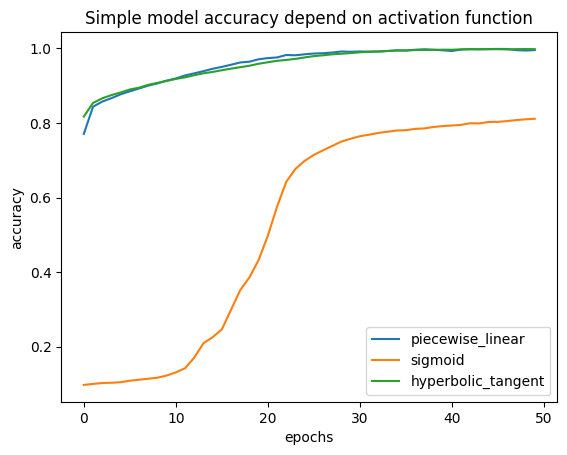

In [41]:
epochs_axis = [x for x in range(epochs)]
for key in activation_funcs.keys():
    plt.plot(epochs_axis, histories[key].history['accuracy'], label=key)
    print(f'Max accuracy for {key} function is {histories[key].history["accuracy"][-1]}')
plt.title('Simple model accuracy depend on activation function')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()